In [4]:
import cobra
from cobra.io import read_sbml_model,load_json_model
from cobra import Model, Reaction, Metabolite
from cobra.medium import minimal_medium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
model = load_json_model('../data/GSMM_parameters/LP_WCFS1.json')

# Pseudo-reactions of EPS repeating unit synthesis

In [6]:
glc_glc_c = Metabolite('glc_glc_c','','EPS intermediate',0,'default')
EPS_c = Metabolite('EPS_c','','EPS repeating unit',0,'default')
EPS_e = Metabolite('EPS_e','','EPS repeating unit',0,'default')
model.add_metabolites([glc_glc_c,EPS_c,EPS_e ])
GT1 = Reaction('GT1','GT1','',0,1000)
GT2 = Reaction('GT2','GT2','',0,1000)
WZX = Reaction('WZX','WZX','',0,1000)
EX_EPS_e = Reaction('EX_EPS_e','EX_EPS_e','',-1000,1000)
model.add_reactions([GT1, GT2, WZX,EX_EPS_e ])

model.reactions.GT1.build_reaction_from_string('udpg_c + glc__D_c --> glc_glc_c + udp_c')
model.reactions.GT2.build_reaction_from_string('udpgal_c + glc_glc_c --> EPS_c + udp_c')
model.reactions.WZX.build_reaction_from_string('EPS_c + atp_c + h2o_c --> EPS_e + adp_c + pi_c +h_c' )
model.reactions.EX_EPS_e.build_reaction_from_string('EPS_e <=> ')

model.objective = {model.reactions.biomass_LPL60: 1}

model.remove_reactions([model.reactions.F6PA,model.reactions.DHAPT, model.reactions.LDH_D,
                       model.reactions.GLCpts, model.reactions.PKL])
#fix directions
model.reactions.PGI.lower_bound = 0.0
model.reactions.FBA.lower_bound = 0.0
model.reactions.GAPD.lower_bound = 0.0
model.reactions.GALU.lower_bound = 0.0
model.reactions.UDPG4E.lower_bound = 0.0
model.reactions.PGK.lower_bound = 0.0
model.reactions.PGM.lower_bound = 0.0
model.reactions.ENO.lower_bound = 0.0
model.reactions.LDH_L.build_reaction_from_string('h_c + nadh_c + pyr_c --> lac__L_c + nad_c')
model.reactions.LDH_L.lower_bound = 0.0
model.reactions.PFL.lower_bound = 0.0
model.reactions.PTAr.lower_bound = 0.0
model.reactions.ACKr.build_reaction_from_string('actp_c + adp_c --> ac_c + atp_c')
model.reactions.ACKr.lower_bound = 0.0

In [4]:
cobra.io.save_json_model(model, "../models/toy.json")

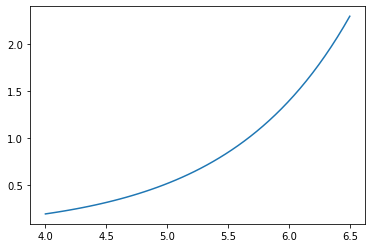

In [7]:
x=np.linspace(4.0,6.5)
k1, k2 = 2.3, 6.5
plt.plot(x, k1/np.exp(k2-x)  ) 

In [7]:
model = load_json_model('../data/GSMM_parameters/toy.json')

In [8]:
A_table = pd.read_csv('../data/GSMM_parameters/toy_params.csv')
A_dict = {A_table['rxn'][i]:A_table['a'][i] for i in A_table.index}

In [9]:
Ptot = 0.299 #g/gDW
def init_medium():
    out_medium = {}
    vitamins = ['EX_btn_e','EX_pnto_R_e', 'EX_ribflv_e', 'EX_thm_e', 'EX_fol_e', 'EX_nac_e','EX_pydam_e']
    DNA_materials = ['EX_ade_e', 'EX_gua_e', 'EX_xan_e', 'EX_ura_e','EX_thymd_e']
    others = ['EX_mn2_e','EX_so4_e', 'EX_h2o_e', 'EX_h_e', 'EX_pi_e', 'EX_nh4_e']
    out_medium['EX_glc_e'] = 100
    for k in ['EX_his_L_e', 'EX_ile_L_e', 'EX_leu_L_e', 'EX_lys_L_e', 'EX_met_L_e', 
                     'EX_phe_L_e', 'EX_thr_L_e', 'EX_trp_L_e', 'EX_val_L_e', 'EX_ala_L_e', 
                     'EX_arg_L_e', 'EX_asn_L_e', 'EX_asp_L_e', 'EX_cys_L_e', 'EX_gln_L_e', 
                     'EX_glu_L_e', 'EX_gly_e', 'EX_pro_L_e', 'EX_ser_L_e', 'EX_tyr_L_e']:
        out_medium[k] = 0.2
    for EX_m in (vitamins+DNA_materials):
        out_medium[EX_m] = 10
    for EX_m in others:
        out_medium[EX_m] = 1000
    return out_medium

def set_PA( model, ptot, a_dict ):
    sigma = 0.5
    # anabolism and transportation
    expr = model.reactions.biomass_LPL60.flux_expression/a_dict['biomass_LPL60'] +\
           model.reactions.EX_glc_e.flux_expression/(-1*a_dict['EX_glc_e'])  +\
           model.reactions.EX_ac_e.flux_expression/(sigma*a_dict['EX_ac_e']) + \
           model.reactions.EX_lac_L_e.flux_expression/(sigma*a_dict['EX_lac_L_e'])
           
    for k in a_dict.keys():
        if ( 'EX_' not in k ) and ( 'biomass' not in k ):
            expr = expr + model.reactions.get_by_id(k).flux_expression/( sigma*a_dict[k] )
            
        
    PA = model.problem.Constraint( expression = expr,name = 'PA', lb= 0, ub = 0.5*ptot)
    model.add_cons_vars([ PA ])
    
    return expr

def pH_effect( model,ptot, a_dict, pH):
    k1, kpH = 0.2, 2
    sigma = 0.5
    ratio = k1*np.exp(   -kpH/((6.5-pH)**2) )
    p_sector = model.reactions.biomass_LPL60.flux_expression/a_dict['biomass_LPL60'] +\
           model.reactions.EX_glc_e.flux_expression/(-1*a_dict['EX_glc_e'])  +\
           model.reactions.EX_ac_e.flux_expression/(sigma*a_dict['EX_ac_e']) + \
           model.reactions.EX_lac_L_e.flux_expression/(sigma*a_dict['EX_lac_L_e'])
    for k in a_dict.keys():
        if ( 'EX_' not in k ) and ( 'biomass' not in k ) and (k!='WZX') and ('GT' not in k):
            p_sector = p_sector + model.reactions.get_by_id(k).flux_expression/( sigma*a_dict[k] )
    
    
    u_sector = model.reactions.GT1.flux_expression/(sigma*a_dict['GT1']) + \
            model.reactions.GT2.flux_expression/(sigma*a_dict['GT2']) + \
            model.reactions.WZX.flux_expression/(sigma*a_dict['WZX'])
    
    pH_effect = model.problem.Constraint( expression = u_sector - ratio * ( p_sector + u_sector ),
                                         name = 'pH_effect', lb= 0, ub = 0 )
    model.add_cons_vars([ pH_effect ])
    
    return u_sector - ratio * ( p_sector + u_sector )
    

In [12]:
Ptot = 0.299
pH = 6.4
with model:
    model.medium = init_medium()
    set_PA( model, Ptot, A_dict )
    pH_effect( model,Ptot, A_dict, pH)
    fluxes = cobra.flux_analysis.pfba(model)
    print(fluxes['biomass_LPL60'])
    print(fluxes['EX_ac_e'])

0.9057157606488422
19.60178973503961


In [14]:
Ptot = 0.299
pH = 4.5
with model:
    model.medium = init_medium()
    set_PA( model, Ptot, A_dict )
    pH_effect( model,Ptot, A_dict, pH)
    fluxes = cobra.flux_analysis.pfba(model)
    print(fluxes['biomass_LPL60'])
    print(fluxes['WZX'])

0.7753234798185679
0.03022544454234624


In [15]:
def predict_diffpH(pH):
    Ptot = 0.299
    with model:
        model.medium = init_medium()
        set_PA( model, Ptot, A_dict )
        pH_effect( model,Ptot, A_dict, pH)
        fluxes = cobra.flux_analysis.pfba(model)
    return fluxes
    

In [16]:
pH_list = np.linspace(4.0,6.4)
grs, EPS_syns = [],[]
for v in pH_list:
    result = predict_diffpH( v )
    grs.append(result['biomass_LPL60'])
    EPS_syns.append(result['WZX'])

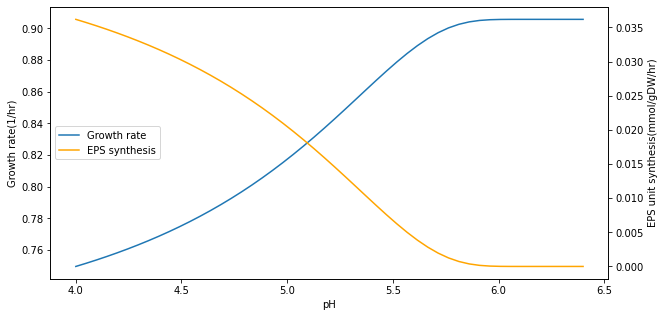

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
l1 = ax.plot(pH_list, grs, label='Growth rate')
ax_0 = ax.twinx()
l2 = ax_0.plot(pH_list,EPS_syns, color = 'orange', label = 'EPS synthesis')
labs = [l.get_label() for l in (l1+l2)]
ax.legend((l1+l2), labs, loc='center left')
ax.set_xlabel('pH')
ax.set_ylabel('Growth rate(1/hr)')
ax_0.set_ylabel('EPS unit synthesis(mmol/gDW/hr)')
plt.savefig('../models/toy_gr_eps.svg',format='svg',dpi=150)

In [24]:
def get_frac(  model, fluxes, ptot, a_dict ):
    sigma = 0.5
    out = {'R':(fluxes['biomass_LPL60']/a_dict['biomass_LPL60'])/ptot }
    out['T'] = (- fluxes['EX_glc_e']/a_dict['EX_glc_e'] + fluxes['EX_ac_e']/(sigma*a_dict['EX_ac_e']) + \
                    fluxes['EX_lac_L_e']/(sigma*a_dict['EX_lac_L_e']) )/ptot
    out['U'] = ( fluxes['GT1']/(sigma*a_dict['GT1']) + \
            fluxes['GT2']/(sigma*a_dict['GT2']) + \
            fluxes['WZX']/(sigma*a_dict['WZX']) )/ptot
    C_cost = 0
    for k in a_dict.keys():
        if ( 'EX_' not in k ) and ( 'biomass' not in k ) and (k!='WZX') and ('GT' not in k):
            C_cost = C_cost  + fluxes[k]/( sigma*a_dict[k] )
    out['C'] = C_cost/ptot
    out['Q'] = 1-(out['U']+out['C']+out['R']+out['T'])
    return out
    

In [25]:
Pcost_dict = {}
for v in [6.4, 5.5, 5.0, 4.5 ]:
    fluxes = predict_diffpH(v)
    Pcost_dict[v] = get_frac(  model, fluxes, 0.299, A_dict )

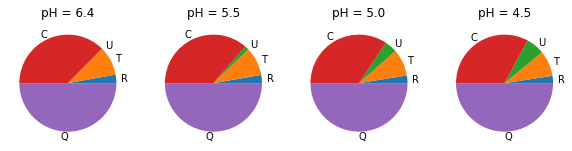

In [36]:
fig,axs=plt.subplots(1,4, figsize=(10,10))
for i in range(len(Pcost_dict.keys())):
    pH = list( Pcost_dict.keys() )[i]
    axs[i].pie( Pcost_dict[pH].values(), labels=Pcost_dict[pH].keys() )
    axs[i].set_title('pH = '+str(pH))
plt.savefig('../models/toy_pa.svg',format='svg',dpi=150)